<h1 align=center><font size = 5>Clustering Neighborhoods in New York City To find Neighborhoods with similar Restaurants</font></h1>

## Introduction

In this, we will convert addresses into their equivalent latitude and longitude values and will use the Foursquare API to explore neighborhoods in New York City. We will use the **explore** function to get the most common restaurant in each neighborhood, and then use this feature to group the neighborhoods into clusters. We will use the *k*-means clustering algorithm to complete this. Finally, We will use the Folium library to visualize the neighborhoods in New York City and their emerging clusters and figure out the clusters with similar restaurants.

## Data

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Feel free to try to find this dataset on your own, but here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572


In [3]:
#Importing all the required libraries.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import folium 
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # plotting library

## 1. Download and Explore Dataset

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
neighborhoods_data = newyork_data['features']

#### Tranform the data into a *pandas* dataframe

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


In [10]:
unique_boroughs_of_NY = neighborhoods['Borough'].unique().tolist()

In [11]:
unique_boroughs_of_NY

['Bronx', 'Manhattan', 'Brooklyn', 'Queens', 'Staten Island']

In [12]:
borough_colors ={}
for i in unique_boroughs_of_NY:
    borough_colors[i] = '#%02X%02X%02X' % tuple(np.random.choice(range(256),size=3))

#### Create a map of New York with neighborhoods superimposed on top.

In [13]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [14]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_colors[borough],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Data Processing to Seperate Manhattan and Brooklyn Borough


In [15]:

neighborhoods1 = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
neighborhoods =neighborhoods[neighborhoods['Borough'] =='Brooklyn'].reset_index(drop=True)
neighborhoods = neighborhoods.append(neighborhoods1)
neighborhoods.head()



Borough Neighborhood   Latitude  Longitude
0  Brooklyn    Bay Ridge  40.625801 -74.030621
1  Brooklyn  Bensonhurst  40.611009 -73.995180
2  Brooklyn  Sunset Park  40.645103 -74.010316
3  Brooklyn   Greenpoint  40.730201 -73.954241
4  Brooklyn    Gravesend  40.595260 -73.973471

In [16]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 2 boroughs and 110 neighborhoods.


## Exploring NewYork Neighborhoods using FourSquare API


In [69]:
CLIENT_ID = 'OchngedCUAT' # your Foursquare ID
CLIENT_SECRET = 'OZWchangedSFPvbbcbvnO5RTAFZM5TS4GEGLPBVI4P' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OchngedCUAT
CLIENT_SECRET:OZWchangedSFPvbbcbvnO5RTAFZM5TS4GEGLPBVI4P


In [18]:
def getNearbyVenues(names, boro, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, boro, lat, lng in zip(names, boro, latitudes, longitudes):
        print("Fetching venues for : ",name)            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            boro,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Borough',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [20]:
NY_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],latitudes=neighborhoods['Latitude'],longitudes=neighborhoods['Longitude'],boro=neighborhoods['Borough'])


Fetching venues for :  Bay Ridge
Fetching venues for :  Bensonhurst
Fetching venues for :  Sunset Park
Fetching venues for :  Greenpoint
Fetching venues for :  Gravesend
Fetching venues for :  Brighton Beach
Fetching venues for :  Sheepshead Bay
Fetching venues for :  Manhattan Terrace
Fetching venues for :  Flatbush
Fetching venues for :  Crown Heights
Fetching venues for :  East Flatbush
Fetching venues for :  Kensington
Fetching venues for :  Windsor Terrace
Fetching venues for :  Prospect Heights
Fetching venues for :  Brownsville
Fetching venues for :  Williamsburg
Fetching venues for :  Bushwick
Fetching venues for :  Bedford Stuyvesant
Fetching venues for :  Brooklyn Heights
Fetching venues for :  Cobble Hill
Fetching venues for :  Carroll Gardens
Fetching venues for :  Red Hook
Fetching venues for :  Gowanus
Fetching venues for :  Fort Greene
Fetching venues for :  Park Slope
Fetching venues for :  Cypress Hills
Fetching venues for :  East New York
Fetching venues for :  Starre

In [21]:
print("Total number of venues found in NY are : ",NY_venues.shape[0])

Total number of venues found in NY are :  2788


In [22]:
NY_venues.head()

Neighborhood   Borough  Neighborhood Latitude  Neighborhood Longitude  \
0    Bay Ridge  Brooklyn              40.625801              -74.030621   
1    Bay Ridge  Brooklyn              40.625801              -74.030621   
2    Bay Ridge  Brooklyn              40.625801              -74.030621   
3    Bay Ridge  Brooklyn              40.625801              -74.030621   
4    Bay Ridge  Brooklyn              40.625801              -74.030621   

                         Venue  Venue Latitude  Venue Longitude Venue Category  
0  Pilo Arts Day Spa and Salon       40.624748       -74.030591            Spa  
1                    Bagel Boy       40.627896       -74.029335     Bagel Shop  
2          Leo's Casa Calamari       40.624200       -74.030931    Pizza Place  
3                Cocoa Grinder       40.623967       -74.030863      Juice Bar  
4          Ho' Brah Taco Joint       40.622960       -74.031371     Taco Place

In [23]:
NY_venues.groupby('Venue Category').count()['Neighborhood'].sort_values(ascending=False).head(10)

Venue Category
Coffee Shop            107
Pizza Place            104
Italian Restaurant      76
Café                    63
Park                    62
Bar                     61
Bakery                  61
Deli / Bodega           56
American Restaurant     52
Grocery Store           52
Name: Neighborhood, dtype: int64

In [24]:
print("Total number of unique categories in NY are : ",len(NY_venues['Venue Category'].unique()))

Total number of unique categories in NY are :  323


### Getting number of venues per neighborhood ###

In [25]:
individual_NY_venue_count = NY_venues.groupby(['Borough','Neighborhood'])['Borough'].count().to_frame()

In [26]:
individual_NY_venue_count

Borough
Borough   Neighborhood               
Brooklyn  Bath Beach               30
          Bay Ridge                30
          Bedford Stuyvesant       28
          Bensonhurst              27
          Bergen Beach              6
...                               ...
Manhattan Upper East Side          30
          Upper West Side          30
          Washington Heights       30
          West Village             30
          Yorkville                30

[110 rows x 1 columns]

In [27]:
individual_NY_venue_count.rename(columns={'Borough':'NumberOfVenues'},inplace=True)
individual_NY_venue_count.reset_index(inplace=True)
individual_NY_venue_count

Borough        Neighborhood  NumberOfVenues
0     Brooklyn          Bath Beach              30
1     Brooklyn           Bay Ridge              30
2     Brooklyn  Bedford Stuyvesant              28
3     Brooklyn         Bensonhurst              27
4     Brooklyn        Bergen Beach               6
..         ...                 ...             ...
105  Manhattan     Upper East Side              30
106  Manhattan     Upper West Side              30
107  Manhattan  Washington Heights              30
108  Manhattan        West Village              30
109  Manhattan           Yorkville              30

[110 rows x 3 columns]

[Text(0, 0, 'Bath Beach'),
 Text(0, 0, 'Bay Ridge'),
 Text(0, 0, 'Bedford Stuyvesant'),
 Text(0, 0, 'Bensonhurst'),
 Text(0, 0, 'Bergen Beach'),
 Text(0, 0, 'Boerum Hill'),
 Text(0, 0, 'Borough Park'),
 Text(0, 0, 'Brighton Beach'),
 Text(0, 0, 'Broadway Junction'),
 Text(0, 0, 'Brooklyn Heights'),
 Text(0, 0, 'Brownsville'),
 Text(0, 0, 'Bushwick'),
 Text(0, 0, 'Canarsie'),
 Text(0, 0, 'Carroll Gardens'),
 Text(0, 0, 'City Line'),
 Text(0, 0, 'Clinton Hill'),
 Text(0, 0, 'Cobble Hill'),
 Text(0, 0, 'Coney Island'),
 Text(0, 0, 'Crown Heights'),
 Text(0, 0, 'Cypress Hills'),
 Text(0, 0, 'Ditmas Park'),
 Text(0, 0, 'Downtown'),
 Text(0, 0, 'Dumbo'),
 Text(0, 0, 'Dyker Heights'),
 Text(0, 0, 'East Flatbush'),
 Text(0, 0, 'East New York'),
 Text(0, 0, 'East Williamsburg'),
 Text(0, 0, 'Erasmus'),
 Text(0, 0, 'Flatbush'),
 Text(0, 0, 'Flatlands'),
 Text(0, 0, 'Fort Greene'),
 Text(0, 0, 'Fort Hamilton'),
 Text(0, 0, 'Fulton Ferry'),
 Text(0, 0, 'Georgetown'),
 Text(0, 0, 'Gerritsen Beach')

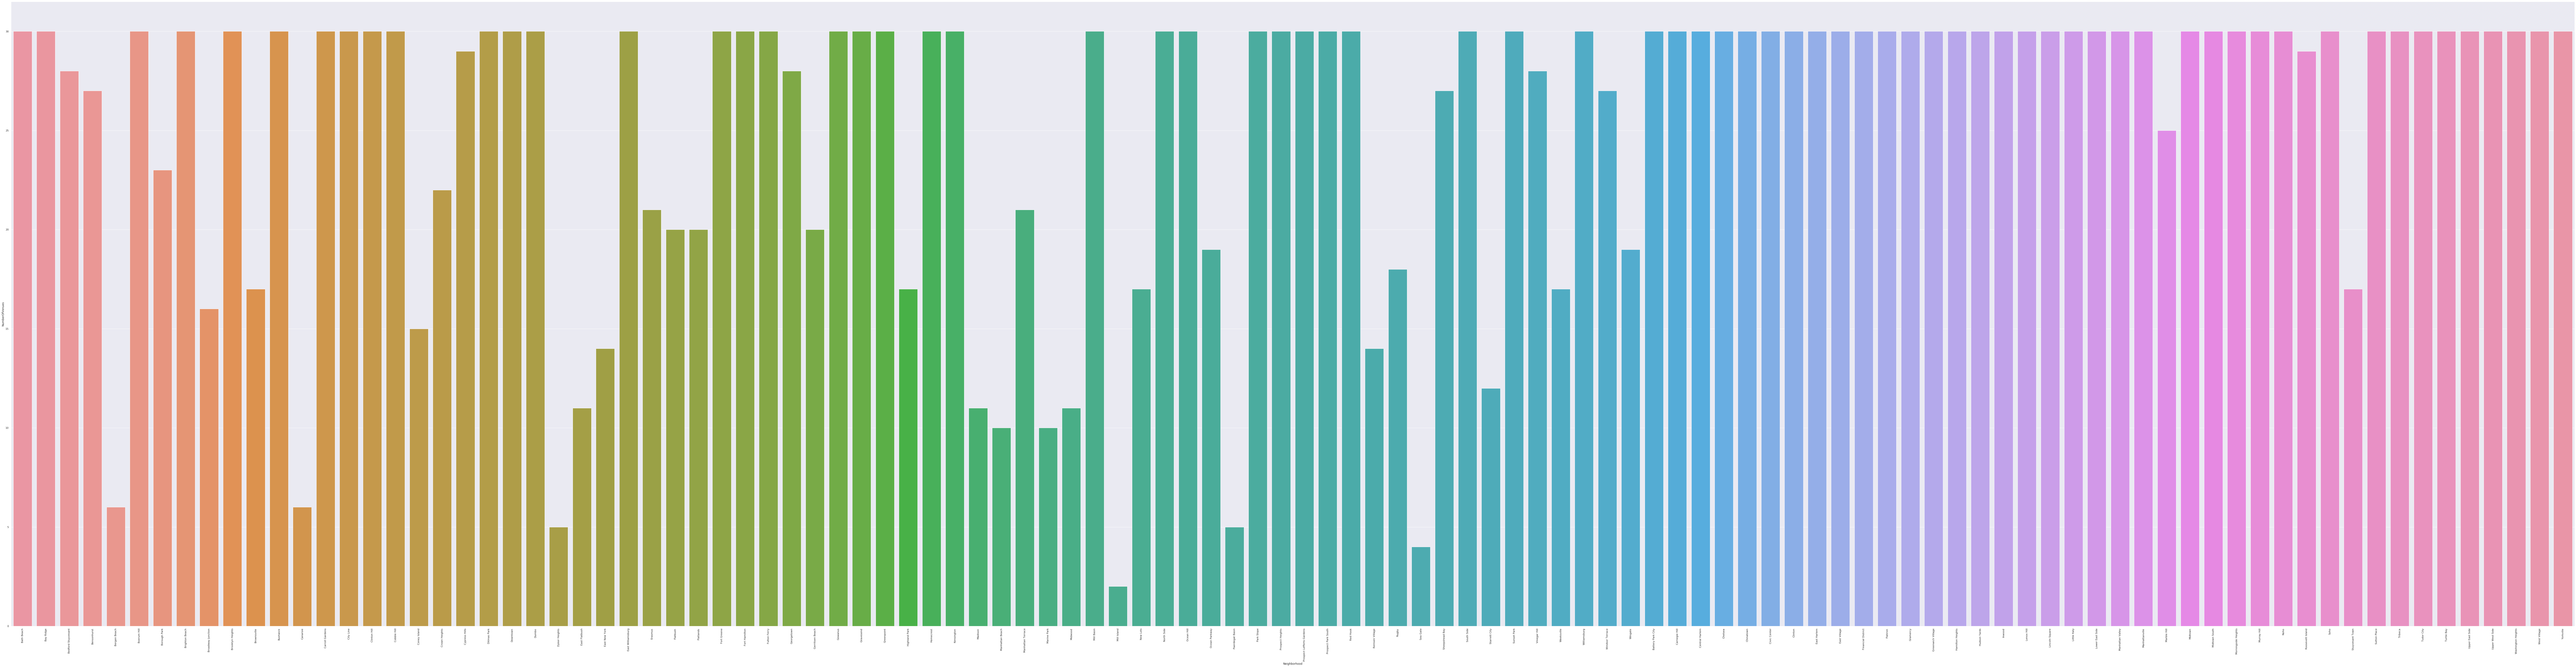

In [28]:
sns.set(rc={'figure.figsize':(200,50)})
plot = sns.barplot(x='Neighborhood',y='NumberOfVenues',data=individual_NY_venue_count)
plot.set_xticklabels(individual_NY_venue_count['Neighborhood'],rotation=90)

In [29]:
NY_venues[NY_venues['Neighborhood']=='Roosevelt Island']

Neighborhood    Borough  Neighborhood Latitude  \
1932  Roosevelt Island  Manhattan               40.76216   
1933  Roosevelt Island  Manhattan               40.76216   
1934  Roosevelt Island  Manhattan               40.76216   
1935  Roosevelt Island  Manhattan               40.76216   
1936  Roosevelt Island  Manhattan               40.76216   
1937  Roosevelt Island  Manhattan               40.76216   
1938  Roosevelt Island  Manhattan               40.76216   
1939  Roosevelt Island  Manhattan               40.76216   
1940  Roosevelt Island  Manhattan               40.76216   
1941  Roosevelt Island  Manhattan               40.76216   
1942  Roosevelt Island  Manhattan               40.76216   
1943  Roosevelt Island  Manhattan               40.76216   
1944  Roosevelt Island  Manhattan               40.76216   
1945  Roosevelt Island  Manhattan               40.76216   
1946  Roosevelt Island  Manhattan               40.76216   
1947  Roosevelt Island  Manhattan               40.76216   
1948  Roosevelt Island  Manhattan               40.76216   
1949  Roosevelt Island  Manhattan               40.76216   
1950  Roosevelt Island  Manhattan               40.76216   
1951  Roosevelt Island  Manhattan               40.76216   
1952  Roosevelt Island  Manhattan               40.76216   
1953  Roosevelt Island  Manhattan               40.76216   
1954  Roosevelt Island  Manhattan               40.76216   
1955  Roosevelt Island  Manhattan               40.76216   
1956  Roosevelt Island  Manhattan               40.76216   
1957  Roosevelt Island  Manhattan               40.76216   
1958  Roosevelt Island  Manhattan               40.76216   
1959  Roosevelt Island  Manhattan               40.76216   
1960  Roosevelt Island  Manhattan               40.76216   

      Neighborhood Longitude                                   Venue  \
1932              -73.949168                                    NISI   
1933              -73.949168              Roosevelt Island Promenade   
1934              -73.949168                   Island Wine & Spirits   
1935              -73.949168        Roosevelt Island Farmer's Market   
1936              -73.949168                          Manhattan Park   
1937              -73.949168                    East Side River Walk   
1938              -73.949168                                  PS 217   
1939              -73.949168                                  Subway   
1940              -73.949168                    One East River Place   
1941              -73.949168                       Wholesome Factory   
1942              -73.949168                               Starbucks   
1943              -73.949168                               Fuji East   
1944              -73.949168                      Manhattan Park Gym   
1945              -73.949168                      Island Shakespeare   
1946              -73.949168                        Capobianco Field   
1947              -73.949168            Roosevelt Island Fruit Stand   
1948              -73.949168                    Blackwell Playground   
1949              -73.949168          475 Main Street Fitness Center   
1950              -73.949168  NYC Social Sports Club - Octagon Field   
1951              -73.949168                       Bikur Cholim Room   
1952              -73.949168                            MTA Q102 Bus   
1953              -73.949168                       Southtown Dog Run   
1954              -73.949168                          Eleanor's Pier   
1955              -73.949168                       Prestige Cleaners   
1956              -73.949168                                 Jupioca   
1957              -73.949168           71st Street Pedestrian Bridge   
1958              -73.949168                           Piccolo Pizza   
1959              -73.949168                        Michelle's Bench   
1960              -73.949168             Gristedes Supermarkets #517   

      Venue Latitude  Venue Longitude  \
1932   

### One hot encoding for letting us to compare different venues based on some common scale ###

In [30]:
NY_venues_onehot = pd.get_dummies(NY_venues[['Venue Category']])

In [31]:
NY_venues_onehot

Venue Category_Accessories Store  Venue Category_Adult Boutique  \
0                                    0                              0   
1                                    0                              0   
2                                    0                              0   
3                                    0                              0   
4                                    0                              0   
...                                ...                            ...   
2783                                 0                              0   
2784                                 0                              0   
2785                                 0                              0   
2786                                 0                              0   
2787                                 0                              0   

      Venue Category_Afghan Restaurant  Venue Category_African Restaurant  \
0                                    0                                  0   
1                                    0                                  0   
2                                    0                                  0   
3                                    0                                  0   
4                                    0                                  0   
...                                ...                                ...   
2783                                 0                                  0   
2784                                 0                                  0   
2785                                 0                                  0   
2786                                 0                                  0   
2787                                 0                                  0   

      Venue Category_American Restaurant  Venue Category_Antique Shop  \
0                                      0                            0   
1                                      0                            0   
2                                      0                            0   
3                                      0                            0   
4                                      0                            0   
...                                  ...                          ...   
2783                                   0                            0   
2784                                   0                            0   
2785                                   0                            0   
2786                                   0                            0   
2787                                   0                            0   

      Venue Category_Arcade  Venue Category_Arepa Restaurant  \
0                         0                                0   
1                         0                                0   
2                         0                                0   
3                         0                                0   
4                         0                                0   
...                     ...                              ...   
2783                      0                                0   
2784                      0                                0   
2785                      0                                0   
2786                      0                                0   
2787                      0                                0   

      Venue Category_Argentinian Restaurant  Venue Category_Art Gallery  ...  \
0                                         0                           0  ...   
1                                         0                           0  ...   
2                                         0                           0  ...   
3                                         0                           0  ...   
4                                         0                           0  ...   
...                                     ...                         ...  ...  

In [32]:
NY_venues_onehot['Neighborhood'] = NY_venues['Neighborhood']
NY_venues_grouped = NY_venues_onehot.groupby('Neighborhood').mean().reset_index()
NY_venues_grouped

Neighborhood  Venue Category_Accessories Store  \
0            Bath Beach                               0.0   
1     Battery Park City                               0.0   
2             Bay Ridge                               0.0   
3    Bedford Stuyvesant                               0.0   
4           Bensonhurst                               0.0   
..                  ...                               ...   
105        West Village                               0.0   
106        Williamsburg                               0.0   
107     Windsor Terrace                               0.0   
108             Wingate                               0.0   
109           Yorkville                               0.0   

     Venue Category_Adult Boutique  Venue Category_Afghan Restaurant  \
0                              0.0                               0.0   
1                              0.0                               0.0   
2                              0.0                               0.0   
3                              0.0                               0.0   
4                              0.0                               0.0   
..                             ...                               ...   
105                            0.0                               0.0   
106                            0.0                               0.0   
107                            0.0                               0.0   
108                            0.0                               0.0   
109                            0.0                               0.0   

     Venue Category_African Restaurant  Venue Category_American Restaurant  \
0                                  0.0                            0.000000   
1                                  0.0                            0.033333   
2                                  0.0                            0.033333   
3                                  0.0                            0.000000   
4                                  0.0                            0.000000   
..                                 ...                                 ...   
105                                0.0                            0.066667   
106                                0.0                            0.000000   
107                                0.0                            0.037037   
108                                0.0                            0.000000   
109                                0.0                            0.000000   

     Venue Category_Antique Shop  Venue Category_Arcade  \
0                       0.000000                    0.0   
1                       0.000000                    0.0   
2                       0.000000                    0.0   
3                       0.000000                    0.0   
4                       0.000000                    0.0   
..                           ...                    ...   
105                     0.000000                    0.0   
106                     0.000000                    0.0   
107                     0.037037                    0.0   
108                     0.000000                    0.0   
109                     0.000000                    0.0   

     Venue Category_Arepa Restaurant  Venue Category_Argentinian Restaurant  \
0                                0.0                                    0.0   
1                                0.0                                    0.0   
2                                0.0                                    0.0   
3                                0.0                                    0.0   
4                                0.0                                    0.0   
..                               ...                                    ...   
105                              0.0                                    0.0   
106                              0.0                                    0.0   
107                              0.0                    

In [33]:
number_of_top_venues = 5

In [34]:
for hood in NY_venues_grouped['Neighborhood']:
    print('---------',hood,'---------')
    temp = NY_venues_grouped[NY_venues_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['Venue','Frequency']
    temp = temp.iloc[1:]
    temp['Frequency'] = temp['Frequency'].astype(float)
    temp = temp.round({'Frequency': 2})
    print(temp.sort_values('Frequency', ascending=False).reset_index(drop=True).head(number_of_top_venues))
    print('\n')

--------- Bath Beach ---------
                                 Venue  Frequency
0    Venue Category_Chinese Restaurant       0.07
1  Venue Category_Fast Food Restaurant       0.07
2       Venue Category_Bubble Tea Shop       0.07
3    Venue Category_Italian Restaurant       0.07
4    Venue Category_Turkish Restaurant       0.03


--------- Battery Park City ---------
                           Venue  Frequency
0   Venue Category_Memorial Site       0.10
1            Venue Category_Park       0.10
2      Venue Category_Food Court       0.07
3  Venue Category_Sandwich Place       0.07
4        Venue Category_Building       0.03


--------- Bay Ridge ---------
                               Venue  Frequency
0         Venue Category_Pizza Place       0.10
1                 Venue Category_Spa       0.10
2    Venue Category_Greek Restaurant       0.07
3  Venue Category_Italian Restaurant       0.07
4       Venue Category_Grocery Store       0.07


--------- Bedford Stuyvesant ---------
    

In [35]:
def return_most_common_venues(row, number_of_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:number_of_top_venues]

In [36]:
number_of_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(number_of_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = NY_venues_grouped['Neighborhood']

for ind in np.arange(NY_venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(NY_venues_grouped.iloc[ind, :], number_of_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood              1st Most Common Venue  \
0          Bath Beach  Venue Category_Italian Restaurant   
1   Battery Park City                Venue Category_Park   
2           Bay Ridge                 Venue Category_Spa   
3  Bedford Stuyvesant         Venue Category_Coffee Shop   
4         Bensonhurst    Venue Category_Sushi Restaurant   

                 2nd Most Common Venue              3rd Most Common Venue  \
0  Venue Category_Fast Food Restaurant     Venue Category_Bubble Tea Shop   
1         Venue Category_Memorial Site          Venue Category_Food Court   
2           Venue Category_Pizza Place    Venue Category_Greek Restaurant   
3         Venue Category_Deli / Bodega                 Venue Category_Bar   
4        Venue Category_Ice Cream Shop  Venue Category_Italian Restaurant   

               4th Most Common Venue               5th Most Common Venue  \
0  Venue Category_Chinese Restaurant           Venue Category_Hookah Bar   
1      Venue Category_Sandwich Place  Venue Category_Monument / Landmark   
2  Venue Category_Italian Restaurant        Venue Category_Grocery Store   
3                Venue Category_Café          Venue Category_Pizza Place   
4  Venue Category_Chinese Restaurant           Venue Category_Donut Shop   

                6th Most Common Venue                7th Most Common Venue  \
0    Venue Category_Mobile Phone Shop  Venue Category_Cantonese Restaurant   
1                  Venue Category_Gym        Venue Category_Scenic Lookout   
2  Venue Category_American Restaurant            Venue Category_Sports Bar   
3             Venue Category_Tiki Bar          Venue Category_Cocktail Bar   
4               Venue Category_Bakery           Venue Category_Coffee Shop   

                   8th Most Common Venue              9th Most Common Venue  \
0               Venue Category_Surf Spot    Venue Category_Sushi Restaurant   
1             Venue Category_Coffee Shop       Venue Category_Movie Theater   
2              Venue Category_Taco Place  Venue Category_Chinese Restaurant   
3  Venue Category_Thrift / Vintage Store           Venue Category_BBQ Joint   
4                     Venue Category_Spa             Venue Category_Butcher   

                  10th Most Common Venue  
0             Venue Category_Gas Station  
1            Venue Category_Gourmet Shop  
2    Venue Category_Caucasian Restaurant  
3              Venue Category_Bagel Shop  
4  Venue Category_Shabu-Shabu Restaurant

In [37]:
neighborhoods_venues_sorted.shape

(110, 11)

### Next to find the optimal k value for clustering using the elbow method

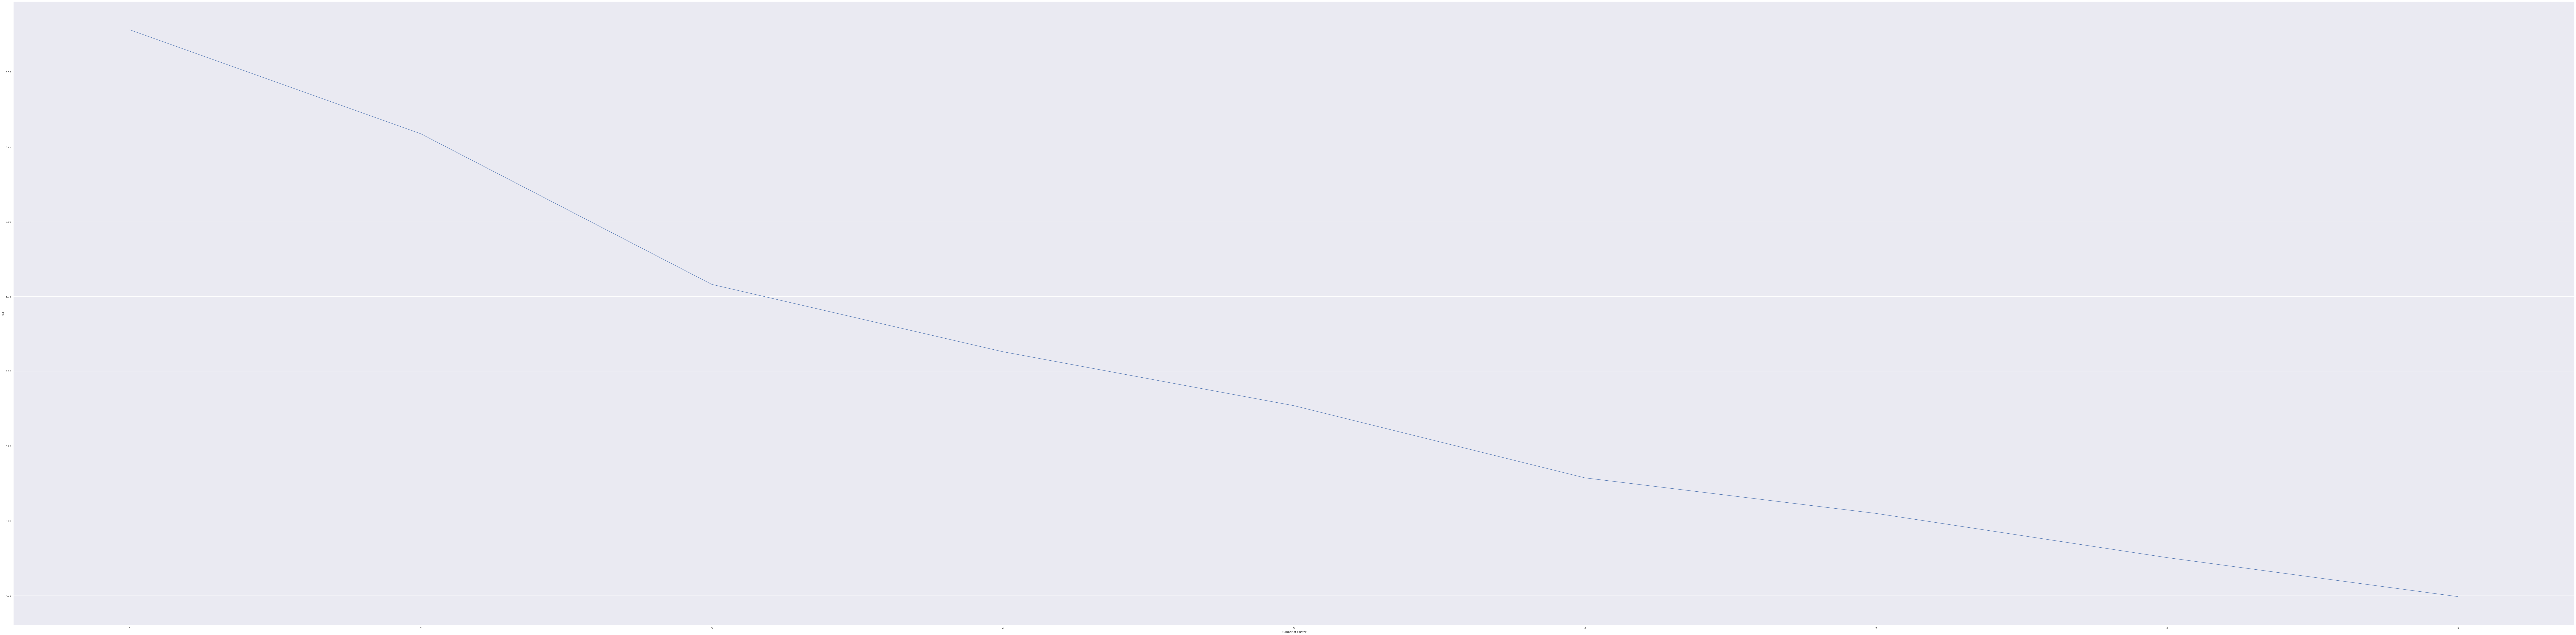

In [38]:
sse = {}
for k in range(1,10):
    kmeans = KMeans(n_clusters=k,random_state=0)
    kmeans.fit(NY_venues_grouped.drop('Neighborhood',axis=1))
    NY_venues_grouped['Cluster'] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

#### we can see the optimal value for cluster is : 3 

In [39]:
kmeans = KMeans(n_clusters=3,random_state=0)

In [40]:
kmeans.fit(NY_venues_grouped.drop('Neighborhood',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [41]:
NY_venues_grouped['Cluster'] = kmeans.labels_

In [42]:
NY_venues_grouped.groupby('Cluster')['Neighborhood'].count()

Cluster
0    36
1    12
2    62
Name: Neighborhood, dtype: int64

In [43]:
NY_venues_grouped.columns

Index(['Neighborhood', 'Venue Category_Accessories Store',
       'Venue Category_Adult Boutique', 'Venue Category_Afghan Restaurant',
       'Venue Category_African Restaurant',
       'Venue Category_American Restaurant', 'Venue Category_Antique Shop',
       'Venue Category_Arcade', 'Venue Category_Arepa Restaurant',
       'Venue Category_Argentinian Restaurant',
       ...
       'Venue Category_Video Store', 'Venue Category_Vietnamese Restaurant',
       'Venue Category_Waterfront', 'Venue Category_Whisky Bar',
       'Venue Category_Wine Bar', 'Venue Category_Wine Shop',
       'Venue Category_Wings Joint', 'Venue Category_Women's Store',
       'Venue Category_Yoga Studio', 'Cluster'],
      dtype='object', length=325)

In [44]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(NY_venues_grouped,on='Neighborhood')

In [45]:
neighborhoods_venues_sorted.head(4)

Neighborhood              1st Most Common Venue  \
0          Bath Beach  Venue Category_Italian Restaurant   
1   Battery Park City                Venue Category_Park   
2           Bay Ridge                 Venue Category_Spa   
3  Bedford Stuyvesant         Venue Category_Coffee Shop   

                 2nd Most Common Venue            3rd Most Common Venue  \
0  Venue Category_Fast Food Restaurant   Venue Category_Bubble Tea Shop   
1         Venue Category_Memorial Site        Venue Category_Food Court   
2           Venue Category_Pizza Place  Venue Category_Greek Restaurant   
3         Venue Category_Deli / Bodega               Venue Category_Bar   

               4th Most Common Venue               5th Most Common Venue  \
0  Venue Category_Chinese Restaurant           Venue Category_Hookah Bar   
1      Venue Category_Sandwich Place  Venue Category_Monument / Landmark   
2  Venue Category_Italian Restaurant        Venue Category_Grocery Store   
3                Venue Category_Café          Venue Category_Pizza Place   

                6th Most Common Venue                7th Most Common Venue  \
0    Venue Category_Mobile Phone Shop  Venue Category_Cantonese Restaurant   
1                  Venue Category_Gym        Venue Category_Scenic Lookout   
2  Venue Category_American Restaurant            Venue Category_Sports Bar   
3             Venue Category_Tiki Bar          Venue Category_Cocktail Bar   

                   8th Most Common Venue              9th Most Common Venue  \
0               Venue Category_Surf Spot    Venue Category_Sushi Restaurant   
1             Venue Category_Coffee Shop       Venue Category_Movie Theater   
2              Venue Category_Taco Place  Venue Category_Chinese Restaurant   
3  Venue Category_Thrift / Vintage Store           Venue Category_BBQ Joint   

   ... Venue Category_Video Store  Venue Category_Vietnamese Restaurant  \
0  ...                        0.0                                   0.0   
1  ...                        0.0                                   0.0   
2  ...                        0.0                                   0.0   
3  ...                        0.0                                   0.0   

   Venue Category_Waterfront  Venue Category_Whisky Bar  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   

   Venue Category_Wine Bar  Venue Category_Wine Shop  \
0                 0.000000                  0.000000   
1                 0.000000                  0.000000   
2                 0.000000                  0.000000   
3                 0.035714                  0.035714   

   Venue Category_Wings Joint  Venue Category_Women's Store  \
0                         0.0                           0.0   
1                         0.0                           0.0   
2                         0.0                           0.0   
3                         0.0                           0.0   

   Venue Category_Yoga Studio  Cluster  
0                         0.0        0  
1                         0.0        2  
2                         0.0        2  
3                         0.0        1  

[4 rows x 335 columns]

In [46]:
neighborhoods_venues_sorted.columns
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(NY_venues,on='Neighborhood')

In [47]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

In [48]:
# set color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_venues_sorted['Neighborhood Latitude'], neighborhoods_venues_sorted['Neighborhood Longitude'], neighborhoods_venues_sorted['Neighborhood'], neighborhoods_venues_sorted['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

In [49]:
map_clusters

### Building a target neighborhood by providing a sample restaurant : Washington Heights	

In [50]:
target_cluster_dataframe = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood']=='Washington Heights']

In [51]:
target_cluster_dataframe.reset_index()

index        Neighborhood 1st Most Common Venue     2nd Most Common Venue  \
0    2605  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
1    2606  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
2    2607  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
3    2608  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
4    2609  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
5    2610  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
6    2611  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
7    2612  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
8    2613  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
9    2614  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
10   2615  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
11   2616  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
12   2617  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
13   2618  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
14   2619  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
15   2620  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
16   2621  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
17   2622  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
18   2623  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
19   2624  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
20   2625  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
21   2626  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
22   2627  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
23   2628  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
24   2629  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
25   2630  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
26   2631  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
27   2632  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
28   2633  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   
29   2634  Washington Heights   Venue Category_Café  Venue Category_Wine Shop   

           3rd Most Common Venue 4th Most Common Venue  \
0   Venue Category_Deli / Bodega   Venue Category_Park   
1   Venue Category_Deli / Bodega   Venue Category_Park   
2   Venue Category_Deli / Bodega   Venue Category_Park   
3   Venue Category_Deli / Bodega   Venue Category_Park   
4   Venue Category_Deli / Bodega   Venue Category_Park   
5   Venue Category_Deli / Bodega   Venue Category_Park   
6   Venue Category_Deli / Bodega   Venue Category_Park   
7   Venue Category_Deli / Bodega   Venue Category_Park   
8   Venue Category_Deli / Bodega   Venue Category_Park   
9   Venue Category_Deli / Bodega   Venue Category_Park   
10  Venue Category_Deli / Bodega   Venue Category_Park   
11  Venue Category_Deli / Bodega   Venue Category_Park   
12  Venue Category_Deli / Bodega   Venue Category_Park   
13  Venue Category_Deli / Bodega   Venue Category_Park   
14  Venue Category_Deli / Bodega   Venue Category_Park   
15  Venue Category_Deli / Bodega   Venue Category_Park   
16  Venue Category_Deli / Bodega   Venue Category_Park   
17  Venue Category_Deli / Bodega   Venue Category_Park   
18  Venue Category_Deli / Bodega   Venue Category_Park   
19  Venue Category_Deli / Bodega   Venue Category_Park   
20  Venue Category_Deli / Bodega   Venue Category_Park   
21  Venue Category_Deli / Bodega   Venue Category_Park   
22  Venue Category_Deli / Bodega   Venue Category_Park   
23  Venue Category_Deli / Bodega   Venue Category_Park   
24  Venue Category_Deli / Bodega   Venue C

In [52]:
target_cluster = target_cluster_dataframe.iloc[0].at['Cluster']

In [53]:
target_cluster

2

In [54]:
possible_neighborhoods = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster']==target_cluster]
possible_neighborhoods.head()

Neighborhood 1st Most Common Venue         2nd Most Common Venue  \
30  Battery Park City   Venue Category_Park  Venue Category_Memorial Site   
31  Battery Park City   Venue Category_Park  Venue Category_Memorial Site   
32  Battery Park City   Venue Category_Park  Venue Category_Memorial Site   
33  Battery Park City   Venue Category_Park  Venue Category_Memorial Site   
34  Battery Park City   Venue Category_Park  Venue Category_Memorial Site   

        3rd Most Common Venue          4th Most Common Venue  \
30  Venue Category_Food Court  Venue Category_Sandwich Place   
31  Venue Category_Food Court  Venue Category_Sandwich Place   
32  Venue Category_Food Court  Venue Category_Sandwich Place   
33  Venue Category_Food Court  Venue Category_Sandwich Place   
34  Venue Category_Food Court  Venue Category_Sandwich Place   

                 5th Most Common Venue 6th Most Common Venue  \
30  Venue Category_Monument / Landmark    Venue Category_Gym   
31  Venue Category_Monument / Landmark    Venue Category_Gym   
32  Venue Category_Monument / Landmark    Venue Category_Gym   
33  Venue Category_Monument / Landmark    Venue Category_Gym   
34  Venue Category_Monument / Landmark    Venue Category_Gym   

            7th Most Common Venue       8th Most Common Venue  \
30  Venue Category_Scenic Lookout  Venue Category_Coffee Shop   
31  Venue Category_Scenic Lookout  Venue Category_Coffee Shop   
32  Venue Category_Scenic Lookout  Venue Category_Coffee Shop   
33  Venue Category_Scenic Lookout  Venue Category_Coffee Shop   
34  Venue Category_Scenic Lookout  Venue Category_Coffee Shop   

           9th Most Common Venue  ... Venue Category_Women's Store  \
30  Venue Category_Movie Theater  ...                          0.0   
31  Venue Category_Movie Theater  ...                          0.0   
32  Venue Category_Movie Theater  ...                          0.0   
33  Venue Category_Movie Theater  ...                          0.0   
34  Venue Category_Movie Theater  ...                          0.0   

    Venue Category_Yoga Studio  Cluster    Borough  Neighborhood Latitude  \
30                         0.0        2  Manhattan              40.711932   
31                         0.0        2  Manhattan              40.711932   
32                         0.0        2  Manhattan              40.711932   
33                         0.0        2  Manhattan              40.711932   
34                         0.0        2  Manhattan              40.711932   

    Neighborhood Longitude                               Venue  \
30              -74.016869         Battery Park City Esplanade   
31              -74.016869  Waterfront Plaza, Brookfield Place   
32              -74.016869                         Hudson Eats   
33              -74.016869            Equinox Brookfield Place   
34              -74.016869             Brookfield Place (BFPL)   

    Venue Latitude  Venue Longitude  Venue Category  
30       40.711622       -74.017907            Park  
31       40.713241       -74.016241           Plaza  
32       40.712666       -74.015901      Food Court  
33       40.712704       -74.014995             Gym  
34       40.713240       -74.015193   Shopping Mall  

[5 rows x 342 columns]

In [55]:
print("There are {} neighborhoods which has similar characteristics to Whitefield.".format(possible_neighborhoods.shape[0]))

There are 1830 neighborhoods which has similar characteristics to Whitefield.


In [56]:
possible_neighborhoods.reset_index().head()

index       Neighborhood 1st Most Common Venue  \
0     30  Battery Park City   Venue Category_Park   
1     31  Battery Park City   Venue Category_Park   
2     32  Battery Park City   Venue Category_Park   
3     33  Battery Park City   Venue Category_Park   
4     34  Battery Park City   Venue Category_Park   

          2nd Most Common Venue      3rd Most Common Venue  \
0  Venue Category_Memorial Site  Venue Category_Food Court   
1  Venue Category_Memorial Site  Venue Category_Food Court   
2  Venue Category_Memorial Site  Venue Category_Food Court   
3  Venue Category_Memorial Site  Venue Category_Food Court   
4  Venue Category_Memorial Site  Venue Category_Food Court   

           4th Most Common Venue               5th Most Common Venue  \
0  Venue Category_Sandwich Place  Venue Category_Monument / Landmark   
1  Venue Category_Sandwich Place  Venue Category_Monument / Landmark   
2  Venue Category_Sandwich Place  Venue Category_Monument / Landmark   
3  Venue Category_Sandwich Place  Venue Category_Monument / Landmark   
4  Venue Category_Sandwich Place  Venue Category_Monument / Landmark   

  6th Most Common Venue          7th Most Common Venue  \
0    Venue Category_Gym  Venue Category_Scenic Lookout   
1    Venue Category_Gym  Venue Category_Scenic Lookout   
2    Venue Category_Gym  Venue Category_Scenic Lookout   
3    Venue Category_Gym  Venue Category_Scenic Lookout   
4    Venue Category_Gym  Venue Category_Scenic Lookout   

        8th Most Common Venue  ... Venue Category_Women's Store  \
0  Venue Category_Coffee Shop  ...                          0.0   
1  Venue Category_Coffee Shop  ...                          0.0   
2  Venue Category_Coffee Shop  ...                          0.0   
3  Venue Category_Coffee Shop  ...                          0.0   
4  Venue Category_Coffee Shop  ...                          0.0   

  Venue Category_Yoga Studio  Cluster    Borough  Neighborhood Latitude  \
0                        0.0        2  Manhattan              40.711932   
1                        0.0        2  Manhattan              40.711932   
2                        0.0        2  Manhattan              40.711932   
3                        0.0        2  Manhattan              40.711932   
4                        0.0        2  Manhattan              40.711932   

   Neighborhood Longitude                               Venue  Venue Latitude  \
0              -74.016869         Battery Park City Esplanade       40.711622   
1              -74.016869  Waterfront Plaza, Brookfield Place       40.713241   
2              -74.016869                         Hudson Eats       40.712666   
3              -74.016869            Equinox Brookfield Place       40.712704   
4              -74.016869             Brookfield Place (BFPL)       40.713240   

   Venue Longitude  Venue Category  
0       -74.017907            Park  
1       -74.016241           Plaza  
2       -74.015901      Food Court  
3       -74.014995             Gym  
4       -74.015193   Shopping Mall  

[5 rows x 343 columns]

In [57]:
possible_neighborhoods.rename(columns={'Neighborhood':'Neighborhoods'},inplace=True)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [59]:
NY_veg = NY_venues_onehot.groupby(['Neighborhood']).sum().reset_index()
NY_veg.head()

Neighborhood  Venue Category_Accessories Store  \
0          Bath Beach                                 0   
1   Battery Park City                                 0   
2           Bay Ridge                                 0   
3  Bedford Stuyvesant                                 0   
4         Bensonhurst                                 0   

   Venue Category_Adult Boutique  Venue Category_Afghan Restaurant  \
0                              0                                 0   
1                              0                                 0   
2                              0                                 0   
3                              0                                 0   
4                              0                                 0   

   Venue Category_African Restaurant  Venue Category_American Restaurant  \
0                                  0                                   0   
1                                  0                                   1   
2                                  0                                   1   
3                                  0                                   0   
4                                  0                                   0   

   Venue Category_Antique Shop  Venue Category_Arcade  \
0                            0                      0   
1                            0                      0   
2                            0                      0   
3                            0                      0   
4                            0                      0   

   Venue Category_Arepa Restaurant  Venue Category_Argentinian Restaurant  \
0                                0                                      0   
1                                0                                      0   
2                                0                                      0   
3                                0                                      0   
4                                0                                      0   

   ...  Venue Category_Video Game Store  Venue Category_Video Store  \
0  ...                                0                           0   
1  ...                                0                           0   
2  ...                                0                           0   
3  ...                                0                           0   
4  ...                                0                           0   

   Venue Category_Vietnamese Restaurant  Venue Category_Waterfront  \
0                                     0                          0   
1                                     0                          0   
2                                     0                          0   
3                                     0                          0   
4                                     0                          0   

   Venue Category_Whisky Bar  Venue Category_Wine Bar  \
0                          0                        0   
1                          0                        0   
2                          0                        0   
3                          0                        1   
4                          0                        0   

   Venue Category_Wine Shop  Venue Category_Wings Joint  \
0                         0                           0   
1                         0                           0   
2                         0                           0   
3                         1                           0   
4                         0                           0   

   Venue Category_Women's Store  Venue Category_Yoga Studio  
0                             0                           0  
1                             0                           0  
2                             0                           0  
3                             0                           0  
4                             0                           0  

[5 rows x 324 columns]

In [60]:
NY_veg['Venue Category_Vegetarian / Vegan Restaurant']

0      0
1      0
2      0
3      0
4      0
      ..
105    0
106    0
107    0
108    0
109    0
Name: Venue Category_Vegetarian / Vegan Restaurant, Length: 110, dtype: uint8

In [61]:
NY_veg = NY_veg[['Neighborhood','Venue Category_Vegetarian / Vegan Restaurant']]
NY_veg.rename(columns={'Venue Category_Vegetarian / Vegan Restaurant':'NumberOfVegRestaurants'},inplace=True)
NY_veg.head()

Neighborhood  NumberOfVegRestaurants
0          Bath Beach                       0
1   Battery Park City                       0
2           Bay Ridge                       0
3  Bedford Stuyvesant                       0
4         Bensonhurst                       0

In [62]:
NY_veg['NumberOfNonVeganrestaurants'] = 1-(NY_veg['NumberOfVegRestaurants']/NY_veg['NumberOfVegRestaurants'].max(axis=0))
NY_veg.head(10)

Neighborhood  NumberOfVegRestaurants  NumberOfNonVeganrestaurants
0          Bath Beach                       0                          1.0
1   Battery Park City                       0                          1.0
2           Bay Ridge                       0                          1.0
3  Bedford Stuyvesant                       0                          1.0
4         Bensonhurst                       0                          1.0
5        Bergen Beach                       0                          1.0
6         Boerum Hill                       0                          1.0
7        Borough Park                       0                          1.0
8      Brighton Beach                       0                          1.0
9   Broadway Junction                       0                          1.0

In [63]:
NY_veg.rename(columns={'Neighborhood':'Neighborhoods'},inplace=True)

In [64]:
possible_neighborhoods = possible_neighborhoods.merge(NY_veg[['Neighborhoods','NumberOfVegRestaurants','NumberOfNonVeganrestaurants']],on='Neighborhoods')

In [65]:
possible_neighborhoods['Ranking'] =  0.5 + possible_neighborhoods['NumberOfNonVeganrestaurants'] * 0.1
recommended_neighborhoods = possible_neighborhoods.sort_values(by='Ranking',ascending=False)
recommended_neighborhoods.reset_index(inplace=True, drop=True)

In [66]:
possible_neighborhoods.head()

Neighborhoods 1st Most Common Venue         2nd Most Common Venue  \
0  Battery Park City   Venue Category_Park  Venue Category_Memorial Site   
1  Battery Park City   Venue Category_Park  Venue Category_Memorial Site   
2  Battery Park City   Venue Category_Park  Venue Category_Memorial Site   
3  Battery Park City   Venue Category_Park  Venue Category_Memorial Site   
4  Battery Park City   Venue Category_Park  Venue Category_Memorial Site   

       3rd Most Common Venue          4th Most Common Venue  \
0  Venue Category_Food Court  Venue Category_Sandwich Place   
1  Venue Category_Food Court  Venue Category_Sandwich Place   
2  Venue Category_Food Court  Venue Category_Sandwich Place   
3  Venue Category_Food Court  Venue Category_Sandwich Place   
4  Venue Category_Food Court  Venue Category_Sandwich Place   

                5th Most Common Venue 6th Most Common Venue  \
0  Venue Category_Monument / Landmark    Venue Category_Gym   
1  Venue Category_Monument / Landmark    Venue Category_Gym   
2  Venue Category_Monument / Landmark    Venue Category_Gym   
3  Venue Category_Monument / Landmark    Venue Category_Gym   
4  Venue Category_Monument / Landmark    Venue Category_Gym   

           7th Most Common Venue       8th Most Common Venue  \
0  Venue Category_Scenic Lookout  Venue Category_Coffee Shop   
1  Venue Category_Scenic Lookout  Venue Category_Coffee Shop   
2  Venue Category_Scenic Lookout  Venue Category_Coffee Shop   
3  Venue Category_Scenic Lookout  Venue Category_Coffee Shop   
4  Venue Category_Scenic Lookout  Venue Category_Coffee Shop   

          9th Most Common Venue  ...    Borough  Neighborhood Latitude  \
0  Venue Category_Movie Theater  ...  Manhattan              40.711932   
1  Venue Category_Movie Theater  ...  Manhattan              40.711932   
2  Venue Category_Movie Theater  ...  Manhattan              40.711932   
3  Venue Category_Movie Theater  ...  Manhattan              40.711932   
4  Venue Category_Movie Theater  ...  Manhattan              40.711932   

   Neighborhood Longitude                               Venue  Venue Latitude  \
0              -74.016869         Battery Park City Esplanade       40.711622   
1              -74.016869  Waterfront Plaza, Brookfield Place       40.713241   
2              -74.016869                         Hudson Eats       40.712666   
3              -74.016869            Equinox Brookfield Place       40.712704   
4              -74.016869             Brookfield Place (BFPL)       40.713240   

   Venue Longitude  Venue Category  NumberOfVegRestaurants  \
0       -74.017907            Park                       0   
1       -74.016241           Plaza                       0   
2       -74.015901      Food Court                       0   
3       -74.014995             Gym                       0   
4       -74.015193   Shopping Mall                       0   

   NumberOfNonVeganrestaurants  Ranking  
0                          1.0      0.6  
1                          1.0      0.6  
2                          1.0      0.6  
3                          1.0      0.6  
4                          1.0      0.6  

[5 rows x 345 columns]

In [67]:
top3 = recommended_neighborhoods.groupby(['Neighborhoods','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue'])['Ranking'].unique()

In [68]:
top3_df = pd.DataFrame(top3).reset_index()
top3_df.head(3)

Neighborhoods            1st Most Common Venue  \
0  Battery Park City              Venue Category_Park   
1          Bay Ridge               Venue Category_Spa   
2        Bensonhurst  Venue Category_Sushi Restaurant   

           2nd Most Common Venue              3rd Most Common Venue Ranking  
0   Venue Category_Memorial Site          Venue Category_Food Court   [0.6]  
1     Venue Category_Pizza Place    Venue Category_Greek Restaurant   [0.6]  
2  Venue Category_Ice Cream Shop  Venue Category_Italian Restaurant   [0.6]

## From the Analysis We can See Neighbourhoods Battery Park City , Bay Ridge and Bensonhurst are similar to Washington Heights